# MORE EFFICIENT PORTFOLIO ALLOCATION WITH QUASI-MONTE CARLO METHODS USING QMCPY
Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

modification date: 08/05/2023

In [2]:

import qmcpy as qp
from qmcpy import *
import pandas as pd
import numpy as np

#!pip install yfinance
import yfinance as yf

from datetime import date
#import seaborn as sn
import matplotlib.pyplot as plt
import time

from scipy.optimize import minimize
import timeit

In [3]:
start_date = '2012-01-01'
#today = date.today()
end_date = '2023-08-04'

In [4]:
def download_data(tickers,description):
    col_names = ['Ticker', 'Company', 'Date', 'Adj Close Price', 'Volume']
    df = pd.DataFrame(columns=col_names)
    for i,ticker in enumerate(tickers):
        company = description[i]
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Ticker'] = ticker
        data['Company'] = company
        data.reset_index(inplace=True)
        data = data[['Ticker', 'Company', 'Date', 'Adj Close', 'Volume']]
        data.columns = col_names
        data.head()
        df = pd.concat([df, data], ignore_index=True)
    return df

In [5]:
def get_log_ret(df):
    stocks = df.pivot(index='Date', columns='Ticker', values='Adj Close Price')
    log_ret = np.log(stocks/stocks.shift(1))

    return log_ret

# generating weights with lattice points

In [6]:
def gen_weights_lattice(n,num_ports):

    l = qp.Lattice(dimension = n, seed = 42)
    weights = l.gen_samples(num_ports) # using lattice points instead of iid
    weights /= np.sum(weights, axis=1)[:, np.newaxis]
    return weights

## generating weights with i.i.d. points

In [7]:
def gen_weights_iid(n,num_ports):
    np.random.seed(42)
    # Generate all weights randomly from continuous uniform distribution in [0,1)
    weights = np.random.random((num_ports, n))
    weights /= np.sum(weights, axis=1)[:, np.newaxis]
    return weights

## computing Sharpe Ratio
Sharpe Ratio is given by: $\frac{R}{V}$, where $R = \sum_{i=1}^{d} R_iw_i$ stands for the excess expected return of a portfolio and $V = \sqrt{\sum_{i=1}^{d} \sum_{j=1}^{d} \sigma_{ij} w_i w_j}$ represents  its expected volatility with $d$ number of assets in a portfolio, weights $w_i$'s, and covariance of assets $i$ and $j$ $\sigma_{ij}$

In [8]:
def sharpe(weights,log_ret):
    np.random.seed(42)
    # Expected return
    ret_arr = np.sum((log_ret.mean().values * weights * 252), axis=1)

    # Expected volatility
    vol_arr = np.sqrt((weights @ (log_ret.cov().values * 252)) @ weights.T).diagonal()

    # Sharpe Ratio
    sharpe_arr = ret_arr/vol_arr

    # Rounding values
    sharpe_arr = np.round(sharpe_arr, decimals=3)
    ret_arr = np.round(ret_arr, decimals=3)
    vol_arr = np.round(vol_arr, decimals=3)
    all_weights = np.round(weights, decimals=3)

    # max
    max_sharpe_ratio = sharpe_arr.max()
    location_in_array = sharpe_arr.argmax()
    max_sr_ret = ret_arr[location_in_array]
    max_sr_vol = vol_arr[location_in_array]
    max_sharpe_ratio = np.round(max_sr_ret/max_sr_vol,decimals=3)

    # mid
    medium_risk_tolerance = np.quantile(vol_arr, 2/3, axis=0)
    medium_risk_idx = np.where(vol_arr<medium_risk_tolerance)
    medium_risk_max_sharpe_ratio = sharpe_arr[medium_risk_idx].max()
    location_in_array = sharpe_arr[medium_risk_idx].argmax()
    medium_risk_sr_ret = ret_arr[medium_risk_idx][location_in_array]
    medium_risk_sr_vol = vol_arr[medium_risk_idx][location_in_array]
    medium_risk_max_sharpe_ratio = np.round(medium_risk_sr_ret/medium_risk_sr_vol,decimals=3)

    # low
    low_risk_tolerance = np.quantile(vol_arr, 1/3, axis=0)
    low_risk_idx = np.where(vol_arr<low_risk_tolerance)
    low_risk_max_sharpe_ratio = sharpe_arr[low_risk_idx].max()
    location_in_array = sharpe_arr[low_risk_idx].argmax()
    low_risk_sr_ret = ret_arr[low_risk_idx][location_in_array]
    low_risk_sr_vol = vol_arr[low_risk_idx][location_in_array]
    low_risk_max_sharpe_ratio = np.round(low_risk_sr_ret/low_risk_sr_vol,decimals =3)

    return {"number of tickers":len(weights[0]),"number of portfolios":len(weights),"low": all_weights[low_risk_idx][location_in_array].tolist(), "medium": all_weights[medium_risk_idx][location_in_array].tolist(), "high": all_weights[location_in_array].tolist(),
            "low risk Sharpe":low_risk_max_sharpe_ratio,"medium risk Sharpe":medium_risk_max_sharpe_ratio,"high risk Sharpe":max_sharpe_ratio}


## Testing
We now test the two approaches by computing Sharpe ratios at different risk levels employing the weights obtained from each method.

As we can see from the tables below, the values of Sharpe ratio do not significantly change based on the number of portfolios. We might want to look furher into this: will results change more significantly if we triple the number of portfolios for the tickers we worked with, or what happens if we use much greater number of tickers to begin with.


In [9]:
tickers = ["AAPL", "AMZN", "CSCO","IBM"]
description = ["Apple", "Amazon", "CISCO", "IBM"]

df = download_data(tickers,description)

# log return for the 4 stocks
lr = get_log_ret(df)


print("\n for lattice points:\n")
w1_qmc = gen_weights_lattice(4,6000)
sr1_qmc = sharpe(w1_qmc,lr)

w2_qmc = gen_weights_lattice(4,10000)
sr2_qmc = sharpe(w2_qmc,lr)

w3_qmc = gen_weights_lattice(4,15000)
sr3_qmc = sharpe(w3_qmc,lr)

data_qmc = {
    'number of tickers': [len(w1_qmc[0]), len(w1_qmc[0]), len(w1_qmc[0])],
    'number of portfolios': [len(w1_qmc),len(w2_qmc),len(w3_qmc)],
    'low risk Sharpe': [sr1_qmc['low risk Sharpe'],sr2_qmc['low risk Sharpe'],sr3_qmc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc['medium risk Sharpe'],sr2_qmc['medium risk Sharpe'],sr3_qmc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc['high risk Sharpe'],sr2_qmc['high risk Sharpe'],sr3_qmc['high risk Sharpe']]

}
df_qmc = pd.DataFrame.from_dict(data_qmc, orient='columns')
df_qmc = df_qmc.pivot(index='number of portfolios', columns='number of tickers')
df_qmc

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



 for lattice points:



,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
6000,0.737,0.810,0.892
10000,0.737,0.815,0.892
15000,0.737,0.815,0.892


In [10]:
np.random.seed(42)

# generate weights with iid points
print("\n for i.i.d. points:\n")

w1_mc = gen_weights_iid(4,6000)
sr1_mc = sharpe(w1_mc,lr)

w2_mc = gen_weights_iid(4,10000)
sr2_mc = sharpe(w2_mc,lr)

w3_mc = gen_weights_iid(4,15000)
sr3_mc = sharpe(w3_mc,lr)

data_mc = {
    'number of tickers': [len(w1_mc[0]), len(w1_mc[0]), len(w1_mc[0])],
    'number of portfolios': [len(w1_mc),len(w2_qmc),len(w3_mc)],
    'low risk Sharpe': [sr1_mc['low risk Sharpe'],sr2_mc['low risk Sharpe'],sr3_mc['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc['medium risk Sharpe'],sr2_mc['medium risk Sharpe'],sr3_mc['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc['high risk Sharpe'],sr2_mc['high risk Sharpe'],sr3_mc['high risk Sharpe']]

}
df_mc = pd.DataFrame.from_dict(data_mc, orient='columns')
df_mc = df_mc.pivot(index='number of portfolios', columns='number of tickers')
df_mc


 for i.i.d. points:



,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,4,4,4
number of portfolios,,,
6000,0.737,0.815,0.892
10000,0.737,0.815,0.892
15000,0.737,0.815,0.892


In [11]:
print("\n for lattice points:\n")

tickers1 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA"]
description1 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna"]
df1 = download_data(tickers1,description1)

lr1 = get_log_ret(df1)

w1_qmc10 = gen_weights_lattice(10,6000)
sr1_qmc10 = sharpe(w1_qmc10,lr1)

w2_qmc10 = gen_weights_lattice(10,10000)
sr2_qmc10 = sharpe(w2_qmc10,lr1)

w3_qmc10 = gen_weights_lattice(10,15000)
sr3_qmc10 = sharpe(w3_qmc10,lr1)

data_qmc10 = {
    'number of tickers': [len(w1_qmc10[0]), len(w1_qmc10[0]), len(w1_qmc10[0])],
    'number of portfolios': [len(w1_qmc10),len(w2_qmc10),len(w3_qmc10)],
    'low risk Sharpe': [sr1_qmc10['low risk Sharpe'],sr2_qmc10['low risk Sharpe'],sr3_qmc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc10['medium risk Sharpe'],sr2_qmc10['medium risk Sharpe'],sr3_qmc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc10['high risk Sharpe'],sr2_qmc10['high risk Sharpe'],sr3_qmc10['high risk Sharpe']]

}
df_qmc10 = pd.DataFrame.from_dict(data_qmc10, orient='columns')
df_qmc10 = df_qmc10.pivot(index='number of portfolios', columns='number of tickers')
df_qmc10

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 for lattice points:




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
6000,0.987,0.992,1.022
10000,0.987,0.992,1.022
15000,0.987,0.996,1.022


In [12]:
np.random.seed(42)
print("\n for i.i.d. points:\n")


w1_mc10 = gen_weights_iid(10,6000)
sr1_mc10 = sharpe(w1_mc10,lr1)

w2_mc10 = gen_weights_iid(10,10000)
sr2_mc10= sharpe(w2_mc10,lr1)

w3_mc10 = gen_weights_iid(10,15000)
sr3_mc10 = sharpe(w3_mc10,lr1)

data_mc10 = {
    'number of tickers': [len(w1_mc10[0]), len(w1_mc10[0]), len(w1_mc10[0])],
    'number of portfolios': [len(w1_mc10),len(w2_qmc10),len(w3_mc10)],
    'low risk Sharpe': [sr1_mc10['low risk Sharpe'],sr2_mc10['low risk Sharpe'],sr3_mc10['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc10['medium risk Sharpe'],sr2_mc10['medium risk Sharpe'],sr3_mc10['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc10['high risk Sharpe'],sr2_mc10['high risk Sharpe'],sr3_mc10['high risk Sharpe']]

}
df_mc10 = pd.DataFrame.from_dict(data_mc10, orient='columns')
df_mc10 = df_mc10.pivot(index='number of portfolios', columns='number of tickers')
df_mc10


 for i.i.d. points:



,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,10,10,10
number of portfolios,,,
6000,0.984,0.996,0.996
10000,0.984,0.996,0.996
15000,0.984,0.996,0.996


In [13]:
print("\n for lattice points:\n")

tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","WBA","GOOGL","BA"]
description2 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna","NASDAQ","AT&T","General Electric","FMC","AMC","JPMorgan","Disney","WBA","Google","Boeing"]

df2 = download_data(tickers2,description2)

lr2 = get_log_ret(df2)

w1_qmc20 = gen_weights_lattice(20,6000)
sr1_qmc20 = sharpe(w1_qmc20,lr2)

w2_qmc20 = gen_weights_lattice(20,10000)
sr2_qmc20 = sharpe(w2_qmc20,lr2)

w3_qmc20 = gen_weights_lattice(20,15000)
sr3_qmc20 = sharpe(w3_qmc20,lr2)

data_qmc20 = {
    'number of tickers': [len(w1_qmc20[0]), len(w1_qmc20[0]), len(w1_qmc20[0])],
    'number of portfolios': [len(w1_qmc20),len(w2_qmc20),len(w3_qmc20)],
    'low risk Sharpe': [sr1_qmc20['low risk Sharpe'],sr2_qmc20['low risk Sharpe'],sr3_qmc20['low risk Sharpe']],
    'medium risk Sharpe': [sr1_qmc20['medium risk Sharpe'],sr2_qmc20['medium risk Sharpe'],sr3_qmc20['medium risk Sharpe']],
    'high risk Sharpe': [sr1_qmc20['high risk Sharpe'],sr2_qmc20['high risk Sharpe'],sr3_qmc20['high risk Sharpe']]

}
df_qmc20 = pd.DataFrame.from_dict(data_qmc20, orient='columns')
df_qmc20 = df_qmc20.pivot(index='number of portfolios', columns='number of tickers')
df_qmc20

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 for lattice points:




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,20,20,20
number of portfolios,,,
6000,0.856,0.918,0.915
10000,0.856,0.918,0.915
15000,0.869,0.918,0.915


In [14]:
np.random.seed(42)
print("\n for i.i.d. points:\n")

w1_mc20 = gen_weights_iid(20,6000)
sr1_mc20 = sharpe(w1_mc20,lr2)

w2_mc20 = gen_weights_iid(20,10000)
sr2_mc20= sharpe(w2_mc20,lr2)

w3_mc20 = gen_weights_iid(20,15000)
sr3_mc20 = sharpe(w3_mc20,lr2)

data_mc20 = {
    'number of tickers': [len(w1_mc20[0]), len(w1_mc20[0]), len(w1_mc20[0])],
    'number of portfolios': [len(w1_mc20),len(w2_mc20),len(w3_mc20)],
    'low risk Sharpe': [sr1_mc20['low risk Sharpe'],sr2_mc20['low risk Sharpe'],sr3_mc20['low risk Sharpe']],
    'medium risk Sharpe': [sr1_mc20['medium risk Sharpe'],sr2_mc20['medium risk Sharpe'],sr3_mc20['medium risk Sharpe']],
    'high risk Sharpe': [sr1_mc20['high risk Sharpe'],sr2_mc20['high risk Sharpe'],sr3_mc20['high risk Sharpe']]

}
df_mc20 = pd.DataFrame.from_dict(data_mc20, orient='columns')
df_mc20 = df_mc20.pivot(index='number of portfolios', columns='number of tickers')
df_mc20


 for i.i.d. points:



,low risk Sharpe,medium risk Sharpe,high risk Sharpe
number of tickers,20,20,20
number of portfolios,,,
6000,0.873,0.873,0.873
10000,0.873,0.873,0.873
15000,0.873,0.885,0.885


## measuring runtime

### real time

In [15]:
# lattice points
start1 = time.time()
tr1 = gen_weights_lattice(4,6000)
end1 = time.time()
time1_qmc = end1-start1
print("takes to run: ", time1_qmc,"for 4 tickers, 6000 portfolios")

start2 = time.time()
tr2 = gen_weights_lattice(10,20000)
end2 = time.time()
time2_qmc = end2 - start2
print("takes to run: ", time2_qmc,"for 10 tickers, 20000 portfolios")

start3 = time.time()
tr3 = gen_weights_lattice(20,30000)
end3 = time.time()
time3_qmc = end3-start3
print("takes to run: ", time3_qmc,"for 20 tickers, 30000 portfolios")

start4 = time.time()
tr4 = gen_weights_lattice(100,150000)
end4 = time.time()
time4_qmc = end4-start4
print("takes to run: ", end4-start4,"for 100 tickers, 150000 portfolios")

start5 = time.time()
tr5 = gen_weights_lattice(500,200000)
end5 = time.time()
time5_qmc = end5- start5
print("takes to run: ", time5_qmc,"for 500 tickers, 200000 portfolios")

start6 = time.time()
tr6 = gen_weights_lattice(1000,500000)
end6 = time.time()
time6_qmc = end6-start6
print("takes to run: ", time6_qmc,"1000 tickers,500000 portfolios")

takes to run:  0.004424095153808594 for 4 tickers, 6000 portfolios
takes to run:  0.01026296615600586 for 10 tickers, 20000 portfolios
takes to run:  0.018870830535888672 for 20 tickers, 30000 portfolios
takes to run:  0.5174500942230225 for 100 tickers, 150000 portfolios
takes to run:  2.7861838340759277 for 500 tickers, 200000 portfolios
takes to run:  17.345120191574097 1000 tickers,500000 portfolios


In [16]:
# iid points
start1_mc = time.time()
tr1 = gen_weights_iid(4,6000)
end1_mc = time.time()
time1_mc = end1_mc - start1_mc
print("takes to run: ", time1_mc,"for 4 tickers, 6000 portfolios")

start2_mc = time.time()
tr2 = gen_weights_iid(10,20000)
end2_mc = time.time()
time2_mc = end2_mc - start2_mc
print("takes to run: ", time2_mc,"for 10 tickers, 20000 portfolios")

start3_mc = time.time()
tr3 = gen_weights_iid(20,30000)
end3_mc = time.time()
time3_mc = end3_mc - start3_mc
print("takes to run: ", time3_mc,"for 20 tickers, 30000 portfolios")

start4_mc = time.time()
tr4 = gen_weights_iid(100,150000)
end4_mc = time.time()
time4_mc = end4_mc - start4_mc
print("takes to run: ", time4_mc,"for 100 tickers, 150000 portfolios")

start5_mc = time.time()
tr5 = gen_weights_iid(500,200000)
end5_mc = time.time()
time5_mc = end5_mc - start5_mc
print("takes to run: ", time5_mc,"for 500 tickers, 200000 portfolios")

start6_mc = time.time()
tr6 = gen_weights_iid(1000,500000)
end6_mc = time.time()
time6_mc = end6_mc - start6_mc
print("takes to run: ", time6_mc,"1000 tickers,500000 portfolios")

takes to run:  0.0021800994873046875 for 4 tickers, 6000 portfolios
takes to run:  0.0011091232299804688 for 10 tickers, 20000 portfolios
takes to run:  0.002580881118774414 for 20 tickers, 30000 portfolios
takes to run:  0.06023597717285156 for 100 tickers, 150000 portfolios
takes to run:  0.3815021514892578 for 500 tickers, 200000 portfolios
takes to run:  1.8311781883239746 1000 tickers,500000 portfolios


Here is the table of real runtime comparison for Monte Carlo and Quasi Monte Carlo Methods


In [17]:
time_data = {'number of tickers': [len(tr1[0]), len(tr2[0]),len(tr3[0]),len(tr3[0]),len(tr4[0]),len(tr6[0])],
    'number of portfolios':[len(tr1),len(tr2),len(tr3),len(tr4),len(tr5),len(tr6)],
    'seconds MC': [time1_mc,time2_mc,time3_mc,time4_mc,time5_mc,time6_mc],
    'seconds QMC': [time1_qmc,time2_qmc,time3_qmc,time4_qmc,time5_qmc,time6_qmc]

}

time_df = pd.DataFrame.from_dict(time_data, orient='columns')
time_df

,number of tickers,number of portfolios,seconds MC,seconds QMC
0,4,6000,0.002180,0.004424
1,10,20000,0.001109,0.010263
2,20,30000,0.002581,0.018871
3,20,150000,0.060236,0.517450
4,100,200000,0.381502,2.786184
5,1000,500000,1.831178,17.345120


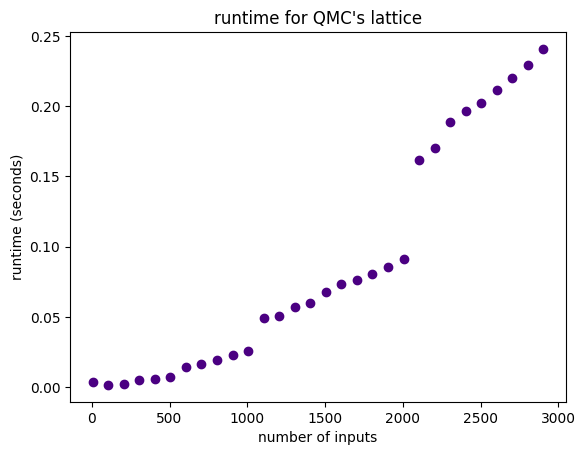

In [18]:
ns = range(5, 3000, 100)
ts = [timeit.timeit('gen_weights_lattice({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns]
plt.plot(ns, ts, color='indigo',marker='o',linestyle='none')
plt.title("runtime for QMC's lattice")
plt.xlabel("number of inputs")
plt.ylabel("runtime (seconds)")
#plt.savefig('qmc-runtime.png')
plt.show()

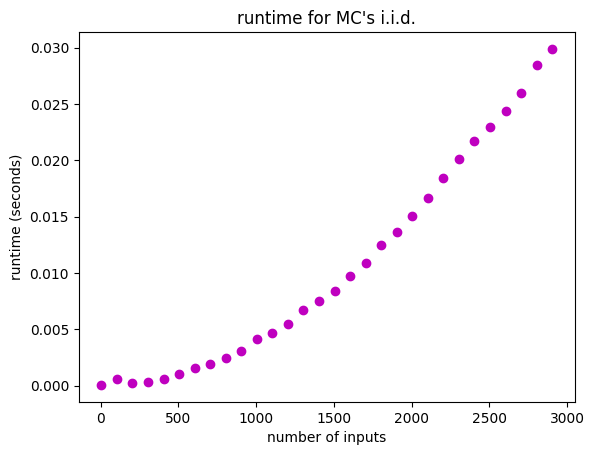

In [19]:
# iid
ns = range(5, 3000,100)
ts = [timeit.timeit('gen_weights_iid({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns]
plt.plot(ns, ts, 'om')
plt.title("runtime for MC's i.i.d.")
plt.xlabel("number of inputs")
plt.ylabel("runtime (seconds)")
#plt.savefig('mc-runtime.png')
plt.show()

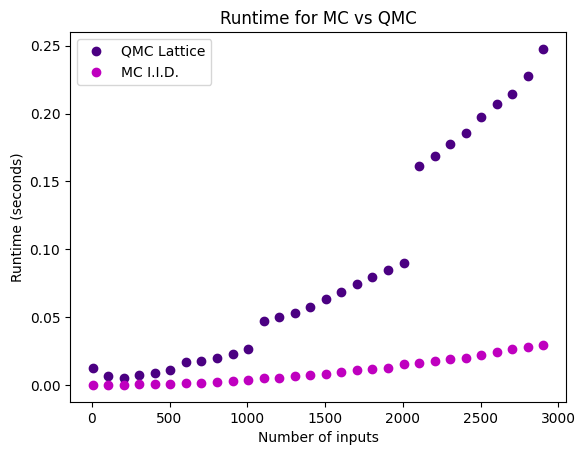

In [20]:
ns = range(5, 3000, 100)
ts = [timeit.timeit('gen_weights_lattice({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns]
plt.plot(ns, ts, color='indigo',marker='o',linestyle='none')


ns1 = range(5, 3000,100)
ts1 = [timeit.timeit('gen_weights_iid({},{})'.format(n,n),
                    globals=globals(),
                    number=1)
         for n in ns1]
plt.plot(ns1, ts1, 'om')

plt.title("Runtime for MC vs QMC")
plt.legend(['QMC Lattice','MC I.I.D.'])
plt.xlabel("Number of inputs")
plt.ylabel("Runtime (seconds)")

plt.show()

### CPU time

In [21]:
from time import process_time
 # lattice
t1_start = process_time()
trial1 = gen_weights_lattice(4,6000)
t1_stop = process_time()
#print("Elapsed CPU time:", t1_stop, t1_start)
print("Elapsed CPU time during the whole program in seconds:",
                                         t1_stop-t1_start,"for 4 tickers, 6000 portfolios")

t2_start = process_time()
trial2 = gen_weights_lattice(10,20000)
t2_stop = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t2_stop-t2_start,"for 10 tickers, 20000 portfolios")
t3_start = process_time()
trial3 = gen_weights_lattice(20,30000)
t3_stop = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t3_stop-t3_start,"for 20 tickers, 30000 portfolios")
t4_start = process_time()
trial4 = gen_weights_lattice(100,150000)
t4_stop = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t4_stop-t4_start,"for 100 tickers, 150000 portfolios")
t5_start = process_time()
trial5 = gen_weights_lattice(500,200000)
t5_stop = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t5_stop-t5_start,"for 500 tickers, 200000 portfolios")
t6_start = process_time()
trial6 = gen_weights_lattice(1000,500000)
t6_stop = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t6_stop-t6_start,"for 1000 tickers, 500000 portfolios")

Elapsed CPU time during the whole program in seconds: 0.4360140000000001 for 4 tickers, 6000 portfolios
Elapsed CPU time during the whole program in seconds: 0.03817899999999952 for 10 tickers, 20000 portfolios
Elapsed CPU time during the whole program in seconds: 0.060600999999991245 for 20 tickers, 30000 portfolios
Elapsed CPU time during the whole program in seconds: 0.943790000000007 for 100 tickers, 150000 portfolios
Elapsed CPU time during the whole program in seconds: 4.795882000000006 for 500 tickers, 200000 portfolios
Elapsed CPU time during the whole program in seconds: 23.398590999999996 for 1000 tickers, 500000 portfolios


In [22]:
t1_s = process_time()
trial1 = gen_weights_iid(4,6000)
t1_end = process_time()
#print("Elapsed CPU time:", t1_stop, t1_start)
print("Elapsed CPU time during the whole program in seconds:",
                                         t1_end-t1_s,"for 4 tickers, 6000 portfolios")

t2_s = process_time()
trial2 = gen_weights_iid(10,20000)
t2_end = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t2_end-t2_s,"for 10 tickers, 20000 portfolios")
t3_s = process_time()
trial3 = gen_weights_iid(20,30000)
t3_end = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t3_end-t3_s,"for 20 tickers, 30000 portfolios")
t4_s = process_time()
trial4 = gen_weights_iid(100,150000)
t4_end = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t4_end-t4_s,"for 100 tickers, 150000 portfolios")
t5_s = process_time()
trial5 = gen_weights_iid(500,200000)
t5_end = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t5_end-t5_s,"for 500 tickers, 200000 portfolios")
t6_s = process_time()
trial6 = gen_weights_iid(1000,500000)
t6_end = process_time()
print("Elapsed CPU time during the whole program in seconds:",
                                         t6_end-t6_s,"for 1000 tickers, 500000 portfolios")

Elapsed CPU time during the whole program in seconds: 0.001350999999999658 for 4 tickers, 6000 portfolios
Elapsed CPU time during the whole program in seconds: 0.0013859999999965567 for 10 tickers, 20000 portfolios
Elapsed CPU time during the whole program in seconds: 0.0026040000000051577 for 20 tickers, 30000 portfolios
Elapsed CPU time during the whole program in seconds: 0.058420999999995615 for 100 tickers, 150000 portfolios
Elapsed CPU time during the whole program in seconds: 0.35928499999999985 for 500 tickers, 200000 portfolios
Elapsed CPU time during the whole program in seconds: 1.7832779999999957 for 1000 tickers, 500000 portfolios


In [23]:
cpu_time_data = {'number of tickers': [len(tr1[0]), len(tr2[0]),len(tr3[0]),len(tr3[0]),len(tr4[0]),len(tr6[0])],
    'number of portfolios':[len(tr1),len(tr2),len(tr3),len(tr4),len(tr5),len(tr6)],
    'seconds MC': [t1_end-t1_s, t2_end-t2_s, t3_end-t3_s, t4_end-t4_s, t5_end-t5_s, t6_end-t6_s],
    'seconds QMC': [t1_stop-t1_start, t2_stop-t2_start, t3_stop-t3_start, t4_stop-t4_start, t5_stop-t5_start, t6_stop-t6_start]

}

cpu_time_df = pd.DataFrame.from_dict(cpu_time_data, orient='columns')
cpu_time_df

,number of tickers,number of portfolios,seconds MC,seconds QMC
0,4,6000,0.001351,0.436014
1,10,20000,0.001386,0.038179
2,20,30000,0.002604,0.060601
3,20,150000,0.058421,0.943790
4,100,200000,0.359285,4.795882
5,1000,500000,1.783278,23.398591


## Backtesting

In [37]:
aapl = df[df['Ticker']== 'AAPL'].reset_index()
amzn = df[df['Ticker']== 'AMZN'].reset_index()
csco = df[df['Ticker']== 'CSCO'].reset_index()
ibm = df[df['Ticker']== 'IBM'].reset_index()

In [38]:
aapl = aapl.set_index('Date')
amzn = amzn.set_index('Date')
csco = csco.set_index('Date')
ibm = ibm.set_index('Date')


In [39]:
# normalize return
for stock_df in (aapl,  amzn, csco, ibm):
    stock_df['Norm Return'] = stock_df['Adj Close Price'] / stock_df.iloc[0]['Adj Close Price']

In [40]:
principal = 10000 # starting investment value
num_ports = 10000
risk_level = "high"
qmc_weights = sr2_qmc
mc_weights =  sr2_mc

### portfolio performance for QMC

In [41]:
# for max sharpe (qmcpy)
for stock_df, allocation in zip((aapl, amzn, csco, ibm), qmc_weights[risk_level]):
    stock_df['Allocation'] = stock_df['Norm Return'] * allocation
    stock_df['Position'] = stock_df['Allocation']*principal

In [42]:
all_pos = [aapl['Position'], amzn['Position'], csco['Position'], ibm['Position']]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = ['AAPL Pos','AMZN Pos', 'CISCO Pos','IBM Pos']
portf_val['Total Pos'] = portf_val.sum(axis=1)
portf_val

,AAPL Pos,AMZN Pos,CISCO Pos,IBM Pos,Total Pos
Date,,,,,
2012-01-03,3440.000000,1810.000000,2450.000000,2300.000000,10000.000000
2012-01-04,3458.486220,1794.632700,2497.342596,2290.617266,10041.078782
2012-01-05,3496.882994,1795.643727,2488.137168,2279.752881,10060.416770
2012-01-06,3533.438782,1846.193914,2478.931556,2253.580108,10112.144361
2012-01-09,3527.833391,1805.248386,2494.713341,2241.851215,10069.646332
...,...,...,...,...,...
2023-07-28,53966.127862,26732.962496,9728.139681,2856.063499,93283.293538
2023-07-31,54136.982397,27030.194760,9718.801347,2870.597488,93756.575992
2023-08-01,53905.500013,26627.817242,9834.590807,2853.674424,93221.582487


### portfolio performance for iid

In [43]:
# max sharpe (iid)
for stock_df_iid, allocation in zip((aapl, amzn, csco, ibm), mc_weights[risk_level]):
    stock_df_iid['Allocation'] = stock_df_iid['Norm Return'] * allocation
    stock_df_iid['Position'] = stock_df_iid['Allocation']*principal

In [44]:
all_pos_iid = [aapl['Position'], amzn['Position'], csco['Position'], ibm['Position']]
portf_val_iid = pd.concat(all_pos_iid, axis=1)
portf_val_iid.columns = ['AAPL Pos','AMZN Pos','CISCO Pos','IBM Pos']
portf_val_iid['Total Pos'] = portf_val_iid.sum(axis=1)
portf_val_iid

,AAPL Pos,AMZN Pos,CISCO Pos,IBM Pos,Total Pos
Date,,,,,
2012-01-03,1360.000000,2400.000000,4890.000000,1350.000000,10000.000000
2012-01-04,1367.308506,2379.623469,4984.491958,1344.492743,10075.916676
2012-01-05,1382.488626,2380.964058,4966.118674,1338.115821,10067.687179
2012-01-06,1396.940914,2447.991930,4947.745024,1322.753542,10115.431410
2012-01-09,1394.724829,2393.699517,4979.244178,1315.869192,10083.537715
...,...,...,...,...,...
2023-07-28,21335.445899,35447.022094,19416.572669,1676.385097,77875.425760
2023-07-31,21402.993041,35841.142223,19397.934117,1684.915917,78326.985298
2023-08-01,21311.476749,35307.602973,19629.040427,1674.982814,77923.102964


In [45]:
qmc_n_mc = [portf_val['Total Pos'],portf_val_iid['Total Pos']]
qmc_vs_mc = pd.concat(qmc_n_mc,axis=1)
qmc_vs_mc.columns = ['QMC Total Pos','MC Total Pos']
qmc_vs_mc

,QMC Total Pos,MC Total Pos
Date,,
2012-01-03,10000.000000,10000.000000
2012-01-04,10041.078782,10075.916676
2012-01-05,10060.416770,10067.687179
2012-01-06,10112.144361,10115.431410
2012-01-09,10069.646332,10083.537715
...,...,...
2023-07-28,93283.293538,77875.425760
2023-07-31,93756.575992,78326.985298
2023-08-01,93221.582487,77923.102964


<AxesSubplot:title={'center':'Portfolio Value for Max Sharpe Ratio'}, xlabel='Date'>

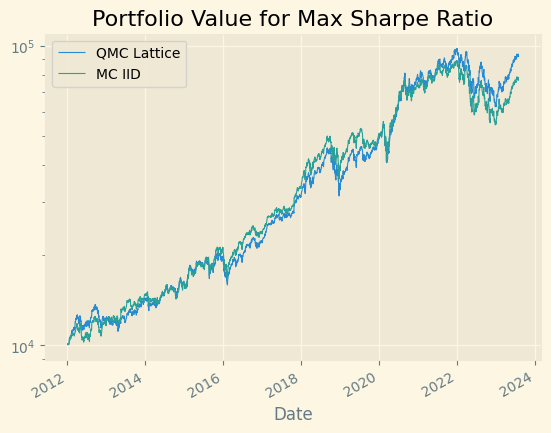

In [46]:
plt.style.use('Solarize_Light2')
qmc_vs_mc.columns = ['QMC Lattice','MC IID']
qmc_vs_mc.plot(title='Portfolio Value for Max Sharpe Ratio', logy=True,linewidth=0.8)

In [47]:
qmc_vs_mc['(QMC - MC)/principal'] = (qmc_vs_mc["QMC Lattice"]-qmc_vs_mc["MC IID"])/principal

<AxesSubplot:title={'center':'Daily difference of QMC and MC portfolio values per invested dollar on 2012-01-01 with 10000 sampling points'}, xlabel='Date'>

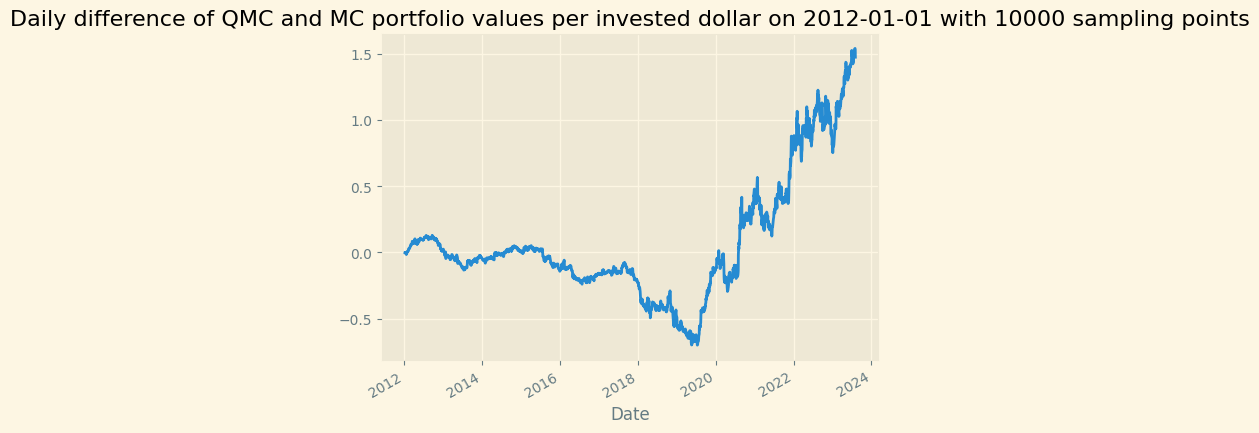

In [48]:
qmc_vs_mc['(QMC - MC)/principal'].plot(title=f"Daily difference of QMC and MC portfolio values per invested dollar on {start_date} with {num_ports} sampling points" )